In [525]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import warnings
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
warnings.filterwarnings(
    action="ignore",
    module="matplotlib",
    message="The 'normed'"
)

In [526]:
#read csv with correct dilimeter and header row
bank = pd.read_csv('bankmarket.csv',sep=';', header=0)
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [527]:
# .isnull() yields 0 null fields, data set uses 'unknown' for null
bank.isin(['unknown']).sum()

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64

In [528]:
'''
# bank client data:
   1 - age (numeric)
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   4 - education (categorical: "unknown","secondary","primary","tertiary")
   5 - default: has credit in default? (binary: "yes","no")
   6 - balance: average yearly balance, in euros (numeric) 
   7 - housing: has housing loan? (binary: "yes","no")
   8 - loan: has personal loan? (binary: "yes","no")
   # related with the last contact of the current campaign:
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
  10 - day: last contact day of the month (numeric)
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  12 - duration: last contact duration, in seconds (numeric)
   # other attributes:
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  15 - previous: number of contacts performed before this campaign and for this client (numeric)
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
  17 - y : outcome
'''

'\n# bank client data:\n   1 - age (numeric)\n   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",\n                                       "blue-collar","self-employed","retired","technician","services") \n   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)\n   4 - education (categorical: "unknown","secondary","primary","tertiary")\n   5 - default: has credit in default? (binary: "yes","no")\n   6 - balance: average yearly balance, in euros (numeric) \n   7 - housing: has housing loan? (binary: "yes","no")\n   8 - loan: has personal loan? (binary: "yes","no")\n   # related with the last contact of the current campaign:\n   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") \n  10 - day: last contact day of the month (numeric)\n  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", 

In [529]:
bank.shape

(45211, 17)

In [530]:
bank.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [531]:
#drop variables with too many 'unknown'
bank = bank.drop(['contact','poutcome'], axis=1)
# unknown to None type
bank.replace({'unknown': None}, inplace=True)
bank.dropna(inplace=True)

In [532]:
tofloat = ['age','balance','day','duration','campaign','pdays','previous']
for i in tofloat:
    bank[i]=bank[i].astype('float64')

In [533]:
'''sns.set(style='whitegrid',palette='mako_r')
g = sns.PairGrid(bank.dropna(), diag_sharey=False)

g.map_upper(plt.scatter, alpha=.5)

g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

g.map_diag(sns.kdeplot, lw=3)
plt.show()'''

"sns.set(style='whitegrid',palette='mako_r')\ng = sns.PairGrid(bank.dropna(), diag_sharey=False)\n\ng.map_upper(plt.scatter, alpha=.5)\n\ng.map_lower(sns.regplot, scatter_kws=dict(alpha=0))\n\ng.map_diag(sns.kdeplot, lw=3)\nplt.show()"

In [534]:
#we may want to try to transform the distributions of the continuous variables to get a normal distribution
squares = pd.DataFrame()
logs = pd.DataFrame()
sqrts = pd.DataFrame()
for col in tofloat:
    squares[col+'_sq'] = bank[col]**2
    sqrts[col+'_sqrt'] = bank[col]**.5
    mask=(bank[col] != 0)
    logable = bank[mask]
    logs.loc[mask, col+'_log'] = np.log(logable[col])
squares.fillna(0, inplace=True)
sqrts.fillna(0, inplace=True)
logs.fillna(0, inplace=True)

C:\Users\willd\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


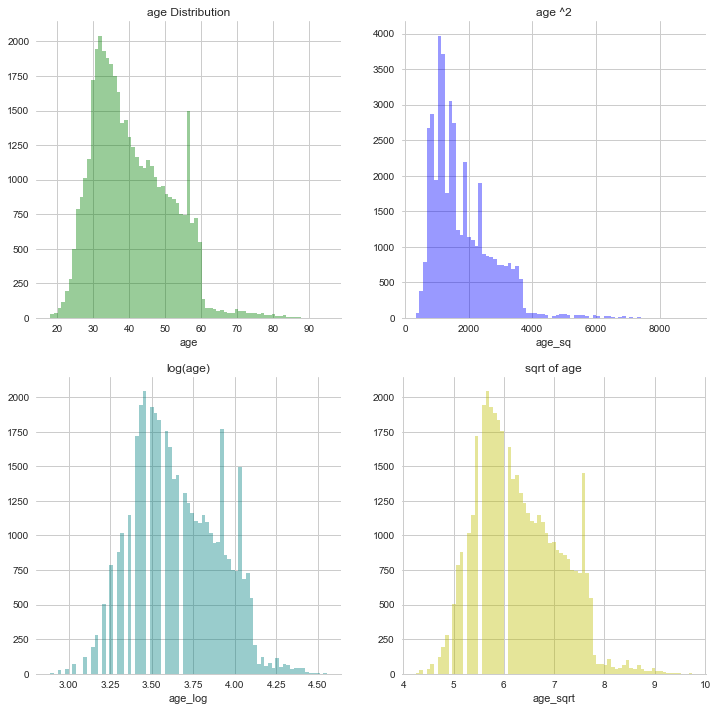

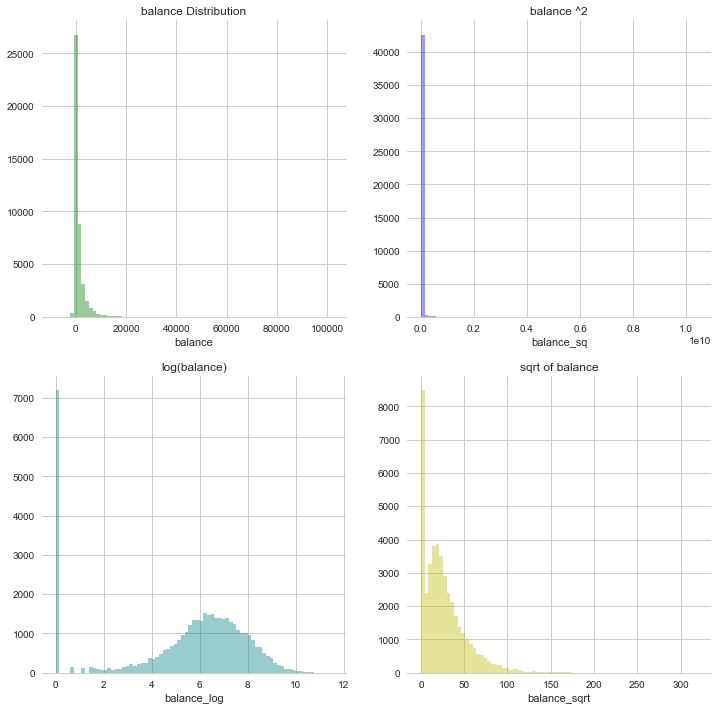

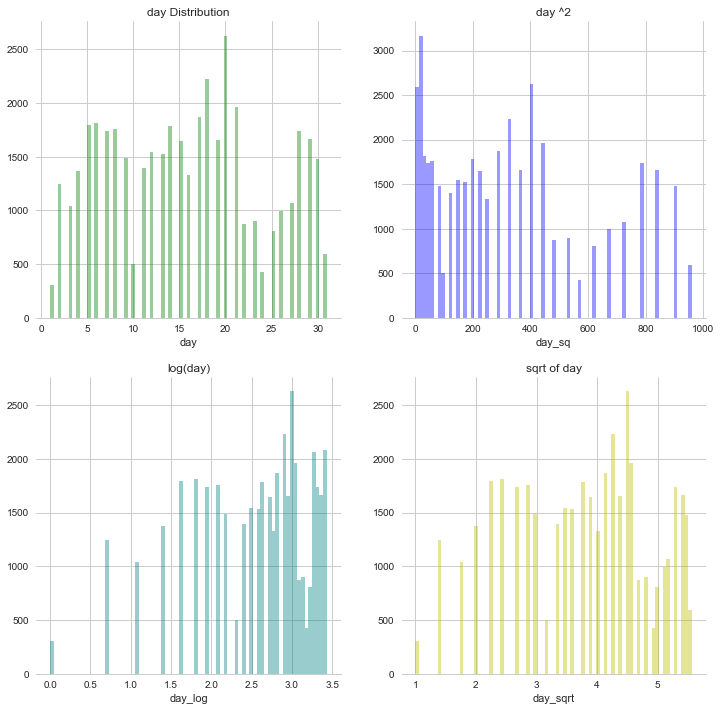

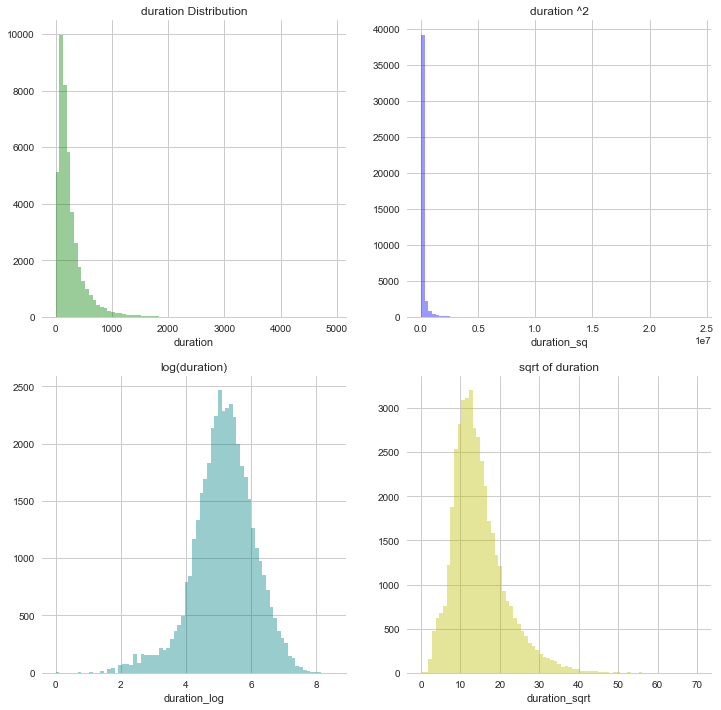

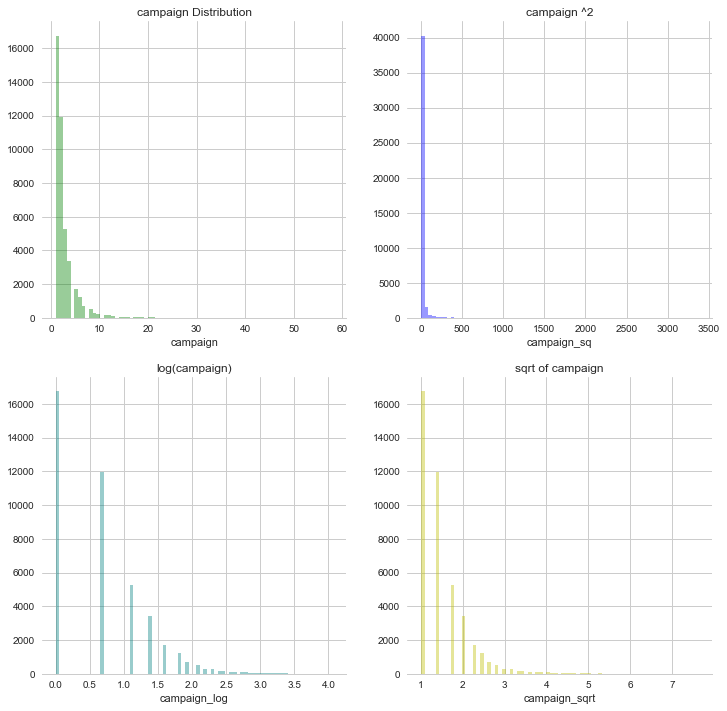

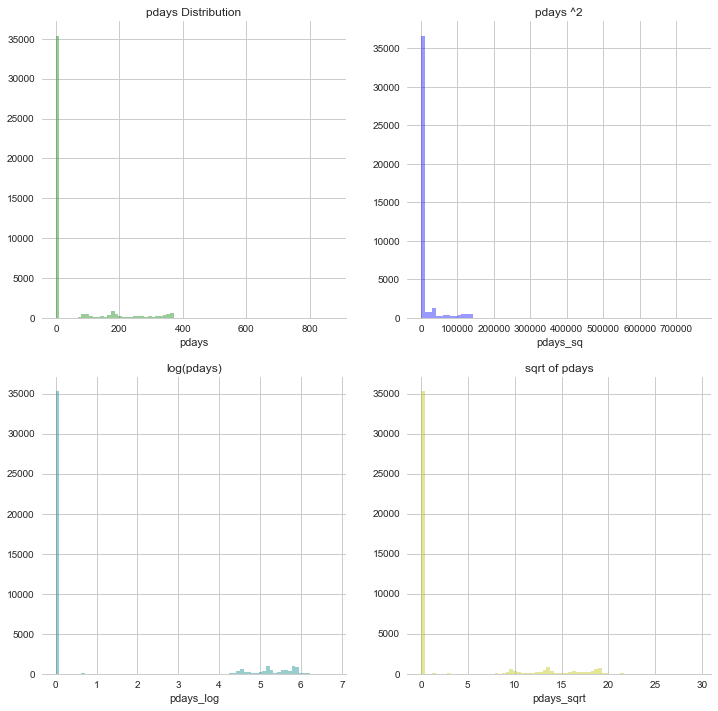

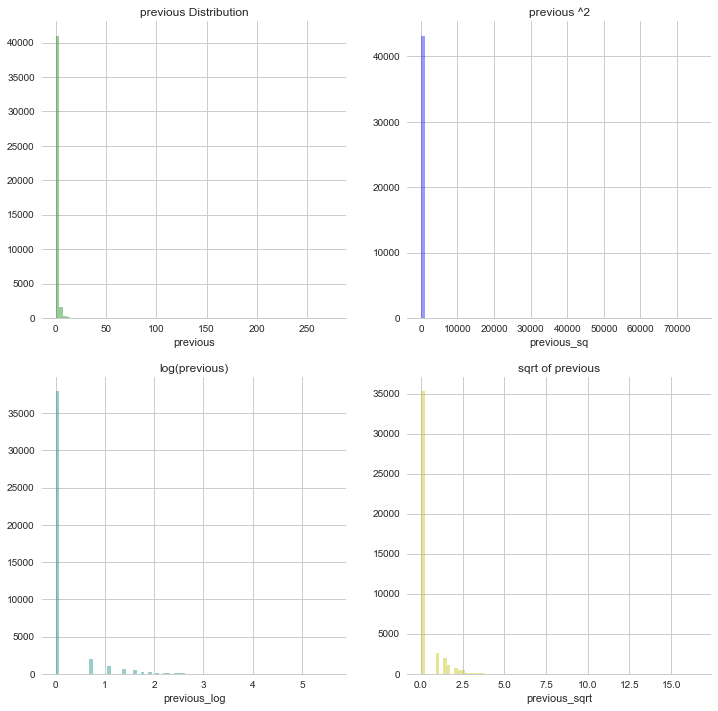

In [535]:
#we may want to try to transform the distributions of the continuous variables
for col in tofloat:
    sns.set(style="whitegrid")
    f, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=False)
    sns.despine(left=True)
    sns.distplot(bank[col], color='g',kde=False,bins=75, ax=axes[0, 0]).set_title("{} Distribution".format(col))
    sns.distplot(squares[col+'_sq'], color='b',kde=False,bins=75,ax=axes[0, 1]).set_title("{} ^2".format(col))
    sns.distplot(logs[col+'_log'],color='teal',kde=False,bins=75, ax=axes[1, 0]).set_title('log({})'.format(col))
    sns.distplot(sqrts[col+'_sqrt'],color='y', kde=False,bins=75, ax=axes[1, 1]).set_title('sqrt of {}'.format(col))
    plt.show()

In [536]:
#We will take log of age and duration later
model = bank.copy()
Y = pd.to_numeric(np.where(model.y=='no',0,1))
X = model.drop(['y'],1)

for col in X.select_dtypes(include=['object']):
    X[col] = X[col].astype('category')
    X[col] = X[col].cat.codes

In [537]:
#Statsmodels results first, then Sklearn

X_statsmod = X.copy()
X_statsmod['intercept'] = 1 
# Declare and fit the model.
logit = sm.Logit(Y, X_statsmod)
result = logit.fit()
print('\n***Using statsmodels framework***\n')
print(result.summary())

print('\n***Using SKlearn framework***\n')
lr = LogisticRegression(C=1e9)
fit = lr.fit(X, Y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)

pred_y_sklearn = lr.predict(X)

print('\n Accuracy by successful marketing attempt status')
print(pd.crosstab(pred_y_sklearn, Y))

print('\n Percentage accuracy')
print(lr.score(X, Y))
print('\nCross Validation Scores\n')
cscores = cross_val_score(lr,X,Y,cv=10)
print(cscores)
print('Mean score {:0.4f}'.format(cscores.mean()))




Optimization terminated successfully.
         Current function value: 0.272664
         Iterations 8

***Using statsmodels framework***

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                43193
Model:                          Logit   Df Residuals:                    43178
Method:                           MLE   Df Model:                           14
Date:                Tue, 25 Sep 2018   Pseudo R-squ.:                  0.2413
Time:                        13:49:36   Log-Likelihood:                -11777.
converged:                       True   LL-Null:                       -15523.
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0068      0.002      3.918      0.000       0.003      

In [538]:
#Run the model again, using get dummies instead of category codes
model = bank.copy()

X = model.drop(['y'],1)
Y = model.y
Y = np.where(Y=='no',0,1)#convert outcome to binary
X = pd.get_dummies(X)

X_statsmod = X.copy()
X_statsmod['intercept'] = 1 
# Declare and fit the model.
logit = sm.Logit(Y, X_statsmod)
result = logit.fit()
print('\n***Using statsmodels framework***\n')
print(result.summary())

print('\n***Using SKlearn framework***\n')
lr = LogisticRegression()
fit = lr.fit(X, Y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)

pred_y_sklearn = lr.predict(X)

print('\n Accuracy by successful marketing attempt status')
print(pd.crosstab(pred_y_sklearn, Y))

print('\n Percentage accuracy')
print(lr.score(X, Y))
print('\nCross Validation Scores\n')
cscores = cross_val_score(lr,X,Y,cv=10)
print(cscores)
print('Mean score {:0.4f}'.format(cscores.mean()))


         Current function value: 0.256386
         Iterations: 35

***Using statsmodels framework***

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                43193
Model:                          Logit   Df Residuals:                    43157
Method:                           MLE   Df Model:                           35
Date:                Tue, 25 Sep 2018   Pseudo R-squ.:                  0.2866
Time:                        13:49:48   Log-Likelihood:                -11074.
converged:                      False   LL-Null:                       -15523.
                                        LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
age                     0.0005      0.002      0.243      0.808      -0.004       0.005
ba

C:\Users\willd\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\willd\Anaconda3\lib\site-packages\statsmodels\base\model.py:1092: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Users\willd\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\willd\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\willd\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Coefficients
[[-8.91276437e-04  1.29574062e-05  1.03635603e-03  4.06377162e-03
  -1.10886669e-01  2.21540249e-03  6.66557281e-02  8.93420155e-02
  -3.06758982e-01 -3.95756817e-01 -4.12264818e-01 -1.53982414e-01
   3.88011290e-01 -2.90070100e-01 -2.12607322e-01  5.72532556e-01
  -1.21321980e-01 -9.04363527e-02 -3.16095358e-01 -4.56062862e-01
  -1.61154704e-01 -5.77582655e-01 -3.40466506e-01 -1.52637639e-02
  -4.28792921e-01 -5.04520003e-01 -4.27536527e-02 -8.90559272e-01
  -1.89920102e-01 -7.43392822e-01 -1.86583912e-02 -6.18859663e-01
   5.36231040e-01 -1.98978721e-01 -1.01752766e+00 -7.56155967e-01
  -5.28726279e-01  1.53401299e+00 -9.71030490e-01 -7.57358995e-01
   9.19225456e-01  9.44513752e-01]]
[-0.93331292]

 Accuracy by successful marketing attempt status
col_0      0     1
row_0             
0      37295  3672
1        877  1349

 Percentage accuracy
0.8946820086588104

Cross Validation Scores

[0.90557741 0.89953704 0.8323686  0.86617273 0.88168558 0.8712665
 0.82102339 0.4075

In [539]:
#Use log of age and duration with category codes
model = bank.copy()
model.age = logs.age_log
model.duration = logs.duration_log
Y = pd.to_numeric(np.where(model.y=='no',0,1))
X = model.drop(['y'],1)

for col in X.select_dtypes(include=['object']):
    X[col] = X[col].astype('category')
    X[col] = X[col].cat.codes

In [540]:
X.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous
0,4.060443,4,1,2,0,2143.0,1,0,5.0,8,5.564520,1.0,-1.0,0.0
1,3.784190,9,2,1,0,29.0,1,0,5.0,8,5.017280,1.0,-1.0,0.0
2,3.496508,2,1,1,0,2.0,1,1,5.0,8,4.330733,1.0,-1.0,0.0
5,3.555348,4,1,2,0,231.0,1,0,5.0,8,4.934474,1.0,-1.0,0.0
6,3.332205,4,2,2,0,447.0,1,1,5.0,8,5.379897,1.0,-1.0,0.0


In [541]:
#Run the fit and get results
X_statsmod = X.copy()
X_statsmod['intercept'] = 1 
# Declare and fit the model.
logit = sm.Logit(Y, X_statsmod)
result = logit.fit()
print('\n***Using statsmodels framework***\n')
print(result.summary())

print('\n***Using SKlearn framework***\n')
lr = LogisticRegression()
fit = lr.fit(X, Y)

# Display.
print('Coefficients')
print(fit.coef_)
print(fit.intercept_)

pred_y_sklearn = lr.predict(X)

print('\n Accuracy by successful marketing attempt status')
print(pd.crosstab(pred_y_sklearn, Y))

print('\n Percentage accuracy')
print(lr.score(X, Y))
print('\nCross Validation Scores\n')
cscores = cross_val_score(lr,X,Y,cv=10)
print(cscores)
print('Mean score {:0.4f}'.format(cscores.mean()))


Optimization terminated successfully.
         Current function value: 0.261355
         Iterations 8

***Using statsmodels framework***

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                43193
Model:                          Logit   Df Residuals:                    43178
Method:                           MLE   Df Model:                           14
Date:                Tue, 25 Sep 2018   Pseudo R-squ.:                  0.2728
Time:                        13:50:00   Log-Likelihood:                -11289.
converged:                       True   LL-Null:                       -15523.
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0159      0.075      0.212      0.832      -0.131      

In [542]:
#look at how regularizing changes the r-squared
#use first model, as it had the highest/most consistent scores

#prepare the data
model = bank.copy()
Y = pd.to_numeric(np.where(model.y=='no',0,1))
X = model.drop(['y'],1)
for col in X.select_dtypes(include=['object']):
    X[col] = X[col].astype('category')
    X[col] = X[col].cat.codes

#fit the model for the starting point
lr = LogisticRegression(C=.01)
fit = lr.fit(X, Y)

accs =[]
estimates = np.append(lr.coef_,[.01])
labels = []
c = []

for i in np.arange(.03,5,.02):    
    lr = LogisticRegression(C=i)
    fit = lr.fit(X, Y)
    accs.append(fit.score(X,Y))
    c.append(i)
    estimates = np.row_stack((
        estimates,
        np.append(lr.coef_,[i])))
    
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X.columns) + ['lambda'])
accs.insert(0,accs[0])



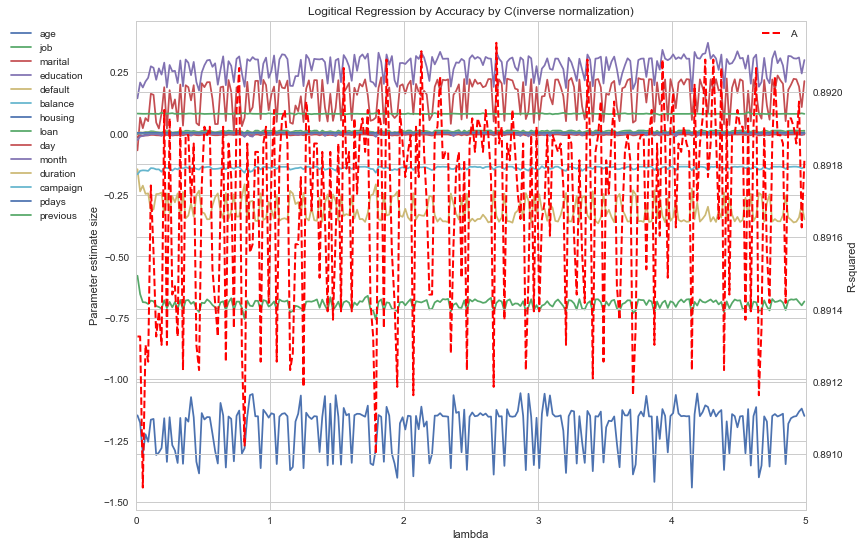


Cross Validation Scores

[0.90719741 0.91087963 0.90715443 0.88261172 0.88863163 0.88376939
 0.86871961 0.86061588 0.88562167 0.86293123]
Mean score 0.8858


In [543]:
fig, ax = plt.subplots(figsize=(12,9))

for col in X:
    ax.plot(estimates_df['lambda'],estimates_df[col])
    labels.append(col)
ax.set_xlabel('lambda')
ax.set_ylabel('Parameter estimate size')
ax.legend(labels,loc='upper left', bbox_to_anchor=(-.2, 1), ncol=1)    
ax2 = ax.twinx()
ax2.plot(estimates_df['lambda'],accs,'--k',color='r',linewidth=2)
ax2.set_ylabel("R-squared")

accc = "Accuracy"
ax2.legend(accc,loc='upper right')

plt.xlim(0,5)
plt.title("Logitical Regression by Accuracy by C(inverse normalization)")
plt.show()
print('\nCross Validation Scores\n')
cscores = cross_val_score(lr,X,Y,cv=10)
print(cscores)
print('Mean score {:0.4f}'.format(cscores.mean()))

In [544]:
lr = LogisticRegression(penalty='l1',C=.01)
fit = lr.fit(X, Y)
accs =[]
estimates = np.append(lr.coef_,[.01])
labels = []


for i in np.arange(.03,5,.02):    
    lr = LogisticRegression(penalty='l1',C=i)
    fit = lr.fit(X, Y)
    accs.append(fit.score(X,Y))
    estimates = np.row_stack((
        estimates,
        np.append(lr.coef_,[i])))
    
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X.columns) + ['lambda'])
accs.insert(0,accs[0])


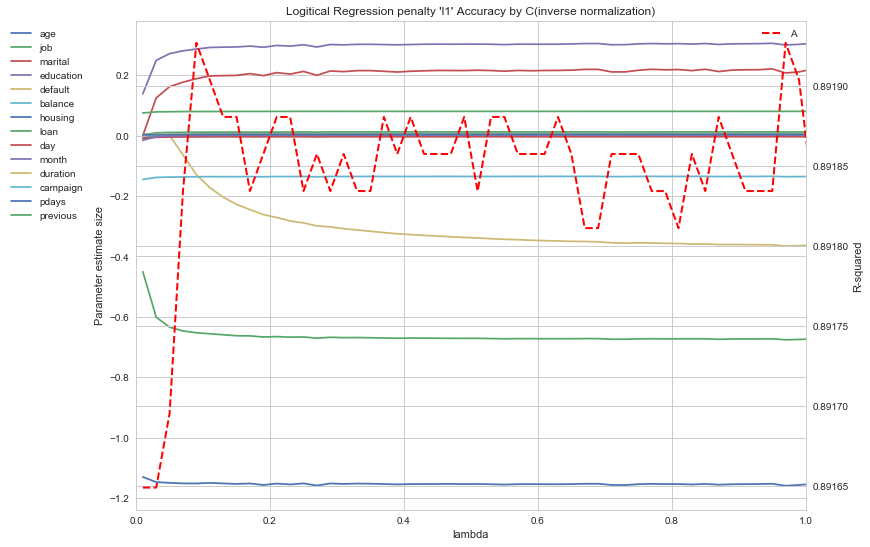


Cross Validation Scores

[0.90766026 0.91111111 0.90900671 0.88261172 0.8890947  0.88330632
 0.86871961 0.86524658 0.88492707 0.86223663]
Mean score 0.8864


In [545]:
fig, ax = plt.subplots(figsize=(12,9))

for col in X:
    ax.plot(estimates_df['lambda'],estimates_df[col])
    labels.append(col)
ax.set_xlabel('lambda')
ax.set_ylabel('Parameter estimate size')
ax.legend(labels,loc='upper left', bbox_to_anchor=(-.2, 1), ncol=1)    
ax2 = ax.twinx()
ax2.plot(estimates_df['lambda'],accs,'--k',color='r',linewidth=2)
ax2.set_ylabel("R-squared")

accc = "Accuracy"
ax2.legend(accc,loc='upper right')

plt.xlim(0,1)
plt.title("Logitical Regression penalty 'l1' Accuracy by C(inverse normalization)")
plt.show()
print('\nCross Validation Scores\n')
cscores = cross_val_score(lr,X,Y,cv=10)
print(cscores)
print('Mean score {:0.4f}'.format(cscores.mean()))

In your report, evaluate all three models and decide on your best. Be clear about the decisions you made that led to these models (feature selection, regularization parameter selection, model evaluation criteria) and why you think that particular model is the best of the three. Also reflect on the strengths and limitations of regression as a modeling approach. Were there things you couldn't do but you wish you could have done?

Record your work and reflections in a notebook to discuss with your mentor.


-The model was chosen based on priliminary performance. 
The original model scored .8857 on a 10 cv cross val
the model with the dummies scorred .81 with huge variance in the accuracy scores
the third model was using log of age and duration

Next, the effect on the r-squared was recorded for ascending values for 'C'. No need to specify l2 for ridge regression as it is the default argument.
Same with penalty='l1'

in the end, the the 'lasso' regression was able to top the mean accuracy with .8864.

The dataset didnt have much multicolinearity, so the regularization did not have huge impact.